In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD

from movie_sentiment.processing.arcs import get_all_reshaped_arcs
from movie_sentiment.params import *

### Standardize arcs and preparing df

In [2]:
arcs = get_all_reshaped_arcs(dyn_avg=True)

Loading data from pickle file


2 following cells are optional (for standardization of the data)

In [3]:
X = arcs.drop(columns='movie_name')

s_scaler = StandardScaler()
s_scaler.fit(X.T)
scaled = s_scaler.transform(X.T)
X_scaled = pd.DataFrame(scaled.T, columns=X.columns)

In [4]:
columns_ids = [i for i in range(30)]

for i in columns_ids:
    arcs[i] = X_scaled[i]

In [5]:
df_reco_1 = arcs.set_index('movie_name')

In [6]:
df_reco_1.head(3)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
movie_name,,,,,,,,,,,,,,,,,,,,,
Fernando Arrabal lit Sa corolle noire ditions A Biren suivi de Ah la belle ann e ditions Ginasservis et Paris,-1.598291,-1.778773,-1.374239,-1.363652,-1.355981,-0.459759,-0.017918,-0.202872,-1.024959,-0.841603,...,1.156356,0.726309,0.116753,-0.662530,-0.368297,-0.362491,-0.242547,0.316914,0.827208,2.184837
It s Kind of a Funny Story,-0.169236,0.593324,1.101164,0.903140,0.965396,0.531421,-0.038163,-0.467987,-0.723052,-0.379225,...,-1.139889,-1.281726,-0.913743,-0.544836,-0.582910,0.173852,0.451509,1.561008,2.286078,0.780361
Neither Seen Nor Recognized,0.127829,0.414927,-0.111587,0.117459,0.435570,0.960243,1.671093,1.368567,1.008647,0.482891,...,-0.914588,-1.498294,-1.752695,-2.210531,-2.025708,-1.432724,-0.888310,0.099751,1.494704,-0.419205


### Find similar movies based on arcs

In [7]:
movie_ex = np.array(df_reco_1.loc['Up']).reshape(1, -1)
similarity_score = cosine_similarity(df_reco_1, movie_ex)

In [8]:
recommendation_df = pd.DataFrame(similarity_score, index = df_reco_1.index)
recommendation_df.sort_values(0, ascending=False, inplace=True)
recommendation_df.head(6)

,0
movie_name,
Up,1.000000
Tarzan s Secret Treasure,0.915319
Limbo,0.900012
Pain and Glory,0.865722
Good Boy,0.863963
Snatch,0.862364


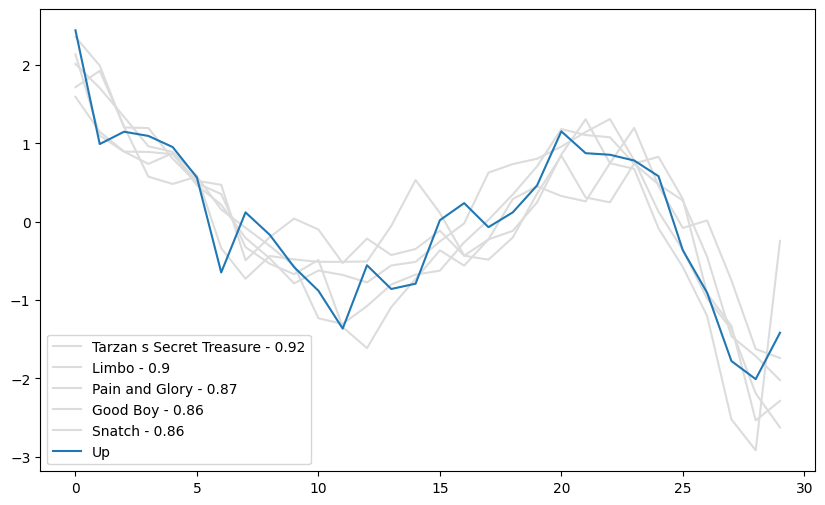

In [9]:
plt.figure(figsize=(10,6))
for row in recommendation_df.iloc[1:6].iterrows():
    id = row[0]
    score = round(row[1][0],2)
    plt.plot(df_reco_1.loc[id], color='gainsboro', label=f"{id} - {score}")

plt.plot(df_reco_1.loc['Up'], label='Up')
plt.legend()

### Get movies metadata

Get data

In [10]:
movie_meta = pd.read_csv('./raw_data/movie_metadata/movie_meta_data.csv')
movie_meta.columns

Index(['imdbid', 'title', 'akas', 'year', 'metascore', 'imdb user rating',
       'number of imdb user votes', 'awards', 'opening weekend', 'producers',
       'budget', 'script department', 'production companies', 'writers',
       'directors', 'casting directors', 'cast', 'countries', 'age restrict',
       'plot', 'plot outline', 'keywords', 'genres', 'taglines', 'synopsis'],
      dtype='object')

In [11]:
movie_meta = movie_meta[['title', 'keywords', 'genres']]

In [12]:
movie_meta.head()

,title,keywords,genres
0,A Night at the Roxbury,"woman-on-top, nightclub, car-accident, 1990s, ...","Comedy, Music, Romance"
1,At First Sight,"visual-agnosia, brother-sister-relationship, r...","Drama, Romance"
2,The Avengers,"good-versus-evil, heroine, evil-man, villain, ...","Action, Adventure, Sci-Fi, Thriller"
3,Bamboozled,"television-industry, african-american, referen...","Comedy, Drama, Music"
4,The Big Lebowski,"rug, nihilism, pornographer, bowling-alley, de...","Comedy, Crime, Sport"


Compute and clean meta data

In [13]:
movie_meta['meta'] = movie_meta['genres'] + ', ' + movie_meta['keywords']

In [14]:
movie_meta['meta'] = movie_meta['meta'].str.replace(',', '')

In [15]:
movie_meta['meta'] = movie_meta['meta'].fillna('')

Convert to vectors

In [16]:
count = CountVectorizer()
count_matrix = count.fit_transform(movie_meta['meta'])
count_df = pd.DataFrame(count_matrix.toarray(), index=movie_meta.index.tolist())

Reduce dimensions

In [17]:
svd = TruncatedSVD(n_components=200)
df_reco_2 = svd.fit_transform(count_df)

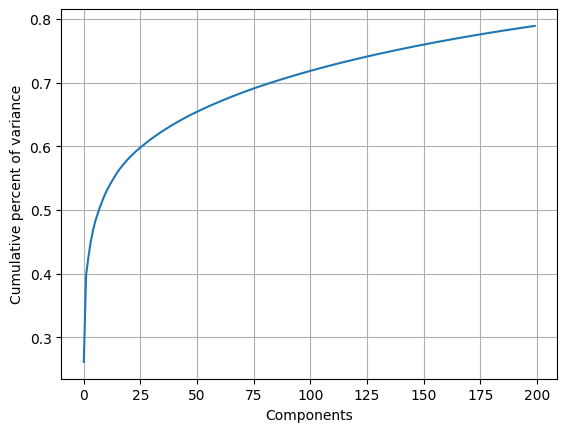

In [18]:
plt.plot(svd.explained_variance_ratio_.cumsum())
plt.xlabel('Components')
plt.ylabel('Cumulative percent of variance')   
plt.grid()
plt.show()

In [19]:
df_reco_2 = pd.DataFrame(df_reco_2, index=movie_meta.title.tolist())
df_reco_2.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
A Night at the Roxbury,1.502832,-0.803807,-2.006379,-0.793780,-0.829672,0.728085,-0.366592,-0.675100,0.999133,0.615035,...,0.016213,-0.064306,0.217867,-0.322714,-0.231015,0.420911,0.063718,-0.147347,-0.027833,-0.018541
At First Sight,1.271576,-0.528864,-2.081561,-0.756035,-0.765354,0.251869,-0.732929,-0.698070,1.380662,-0.888438,...,-0.034038,-0.073445,0.123263,-0.203330,-0.184840,-0.212757,0.110566,0.135397,-0.183481,-0.046531
The Avengers,6.607973,-1.739845,0.476277,1.615551,2.167067,3.640551,0.082123,1.565535,1.681950,1.472499,...,0.144013,0.439344,-0.590421,0.188913,-0.070202,0.514866,-0.380889,0.442436,-0.375975,-0.534734
Bamboozled,58.035444,50.585552,5.012842,2.557669,-2.838908,2.143097,-4.067179,3.284438,-0.802079,-4.157638,...,0.842382,-0.627385,-1.409009,-1.823963,-0.278117,0.469496,-0.495737,0.561923,-0.268622,-0.184049
The Big Lebowski,27.097305,-9.668266,-4.641154,-2.699650,5.027355,6.497558,-2.757835,-0.893013,-3.081686,2.475940,...,-1.404858,-1.105724,0.523717,0.502504,-1.682004,1.053043,-0.049445,-2.424247,1.104341,0.171315


### Find similar movies based on arcs and meta

Compute similarities for a movie

In [33]:
movie_ex1 = np.array(df_reco_1.loc['Aladdin']).reshape(1, -1)
movie_ex2 = np.array(df_reco_2.loc['Aladdin']).reshape(1, -1)

similarity_score1 = cosine_similarity(df_reco_1, movie_ex1)
similarity_score2 = cosine_similarity(df_reco_2, movie_ex2)

Regroup in a DataFrame

In [34]:
scores_df1 = pd.DataFrame(similarity_score1, index = df_reco_1.index)
scores_df1.sort_values(0, ascending=False, inplace=True)
scores_df1.columns = ['arcs']

scores_df2 = pd.DataFrame(similarity_score2, index = df_reco_2.index)
scores_df2.sort_values(0, ascending=False, inplace=True)
scores_df2.columns = ['meta']

In [35]:
scores_df = pd.merge(scores_df1, scores_df2, left_index=True, right_index=True)

Compute a global score and select movies

In [36]:
scores_df['total'] = (scores_df['arcs'] + scores_df['meta']) / 2.0

scores_df.sort_values(by=['total'], ascending=False, inplace=True)

scores_df.drop(['Aladdin'], inplace=True)

scores_df.head(5)

,arcs,meta,total
movie_name,,,
Some Like It Hot,0.937132,0.706994,0.822063
La La Land,0.822829,0.819758,0.821294
Tully,0.770875,0.835460,0.803167
The Bucket List,0.777420,0.787028,0.782224
Boys on the Side,0.902178,0.657065,0.779621


Some Like It Hot
La La Land
Tully
The Bucket List
Boys on the Side


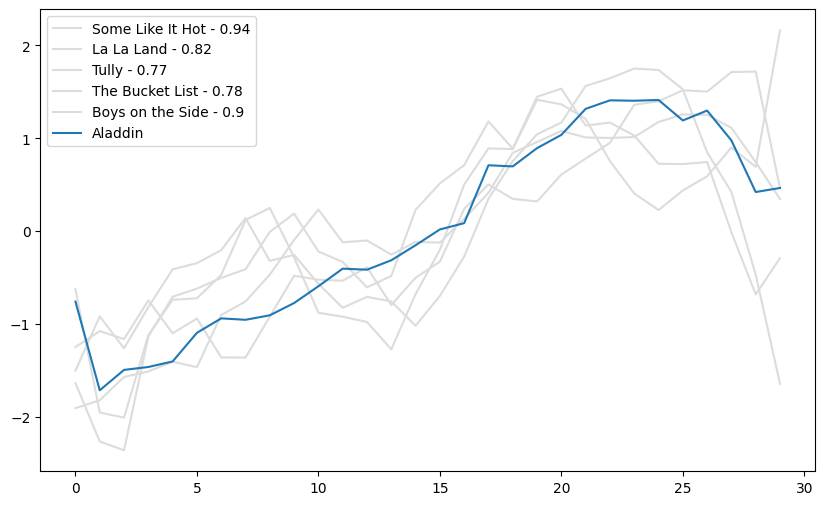

In [37]:
plt.figure(figsize=(10,6))
for row in scores_df.iloc[0:5].iterrows():
    id = row[0]
    print(id)
    score = round(row[1][0],2)
    plt.plot(df_reco_1.loc[id], color='gainsboro', label=f"{id} - {score}")

plt.plot(df_reco_1.loc['Aladdin'], label='Aladdin')
plt.legend()

### Test the function

In [25]:
%load_ext autoreload
%autoreload 2

from movie_sentiment.ml_logic.recommendation import get_movies_recommendation

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
get_movies_recommendation('Up', n=5)

Loading data from pickle file
Loading metadata from pickle file


{'movie_names': ['Coco',
  'How to Train Your Dragon',
  'To Kill a Mockingbird',
  'Jojo Rabbit',
  'Beauty and the Beast'],
 'movie_scores': [0.72, 0.72, 0.7, 0.7, 0.69]}

### Polynomials

In [27]:
from movie_sentiment.processing.arcs import get_all_polynomials

In [28]:
arcs = get_all_polynomials()

Loading data from pickle file


In [29]:
df_poly = arcs.set_index('movie_name')

In [30]:
movie_ex = np.array(df_poly.loc['Up']).reshape(1, -1)
similarity_score = cosine_similarity(df_poly, movie_ex)

In [31]:
recommendation_df = pd.DataFrame(similarity_score, index = df_poly.index)
recommendation_df.sort_values(0, ascending=False, inplace=True)
recommendation_df.head(6)

,0
movie_name,
Up,1.0
The Great Outdoors,1.0
The Insider,1.0
Star Trek III The Search for Spock,1.0
A Few Good Men,1.0
The Rage Carrie 2,1.0


Plotting polynomials

In [32]:
# x_fit = np.arange(30)
# y_fit = np.polyval(coefficients, x_fit)
# plt.plot(x_fit, y_fit, 'r')


for row in recommendation_df.head(10).iterrows():
    id = row[0]
    if id !=0:
        print(df_poly.loc[id])
        y_fit = np.polyval(df_poly.loc[id], x_fit)
        plt.plot(x_fit, y_fit, color='gainsboro')
        
plt.plot(df_reco_1.loc[id])

0     0.000000e+00
1     0.000000e+00
2     0.000000e+00
3     0.000000e+00
4     0.000000e+00
5     0.000000e+00
6     3.278383e-09
7    -1.626563e-06
8     2.526939e-04
9    -1.316647e-02
10    3.241072e-01
Name: Up, dtype: float64


NameError: name 'x_fit' is not defined

Plotting curves

In [ ]:
for row in recommendation_df.head(10).iterrows():
    id = row[0]
    if id !=0:
        plt.plot(df_reco_1.loc[id], color='gainsboro')
        
plt.plot(df_reco_1.loc[id])